# Energy Consumption Predictions with Bayesian LSTMs in PyTorch

Author: Pawarit Laosunthara



# **Important Note for GitHub Readers:**
Please click the **Open in Colab** button above in order to view all **interactive visualizations**.

This notebook demonstrates an implementation of an (Approximate) Bayesian Recurrent Neural Network in PyTorch, originally inspired by the *Deep and Confident Prediction for Time Series at Uber* (https://arxiv.org/pdf/1709.01907.pdf)

<br>

In this approach, Monte Carlo dropout is used to **approximate** Bayesian inference, allowing our predictions to have explicit uncertainties and confidence intervals. This property makes Bayesian Neural Networks highly appealing to critical applications requiring uncertainty quantification.
The *Appliances energy prediction* dataset used in this example is from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction)


**Note:** this notebook purely serves to demonstrate the implementation of Bayesian LSTMs (Long Short-Term Memory) networks in PyTorch. Therefore, extensive data exploration and feature engineering is not part of the scope of this investigation.

# Preliminary Data Wrangling

**Selected Columns:**

For simplicity and speed when running this notebook, only temporal and autoregressive features are used.

- date time year-month-day hour:minute:second, sampled every 10 minutes \
- Appliances, energy use in Wh for the corresponding 10-minute timestamp \
- day_of_week, where Monday corresponds to 0 \
- hour_of_day


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn 

In [2]:
data = pd.read_csv("/home/jik19004/FilesToRun/ASOS_10_CT_stations_tmpc_demand_2011_2023.csv").drop(columns=["Unnamed: 0"])
data.head()

,Datetime,BDL_tmpc,BDR_tmpc,DXR_tmpc,GON_tmpc,HFD_tmpc,HVN_tmpc,IJD_tmpc,MMK_tmpc,OXC_tmpc,SNC_tmpc,Demand
0,1/1/2011 0:00,1.11,1.11,0.00,2.78,1.67,1.11,-2.78,-1.67,3.0,2.0,3053.0
1,1/1/2011 1:00,1.11,2.22,-0.56,3.33,2.22,3.33,-2.78,-1.67,3.0,3.0,2892.0
2,1/1/2011 2:00,-0.56,2.78,-1.67,3.33,2.78,2.78,-2.22,0.56,3.0,3.0,2774.0
3,1/1/2011 3:00,-1.11,2.22,-1.11,3.89,2.22,1.11,-2.78,0.56,2.0,4.0,2710.0
4,1/1/2011 4:00,-1.67,1.67,-1.11,3.33,2.22,-0.56,-2.78,-1.67,4.0,5.0,2698.0


In [3]:
from datetime import datetime 

WeatherData = pd.read_csv('/home/jik19004/FilesToRun/ASOS_10_CT_stations_tmpc_demand_2011_2023.csv').drop(columns = ["Unnamed: 0"])
WeatherData.ffill(inplace = True)
WeatherData.bfill(inplace = True) # fill in missing values with the previous value.
DateTimeCol = WeatherData["Datetime"]
HourCol = []
WeekDayorWeekEndCol = [] 

for date in DateTimeCol:
    date = datetime.strptime(date, "%m/%d/%Y %H:%M")
    HourCol.append(date.hour)
    if date.weekday() < 5:
        WeekDayorWeekEndCol.append(0)
    else:
        WeekDayorWeekEndCol.append(1)

WeatherData.drop(columns = ["Datetime"], inplace = True) # drop the datetime column. 


WeatherData.insert(0, "Hour", HourCol)
WeatherData.insert(1, "Weekday or Weekend", WeekDayorWeekEndCol)

In [4]:
DateTimeCol = [datetime.strptime(date, "%m/%d/%Y %H:%M") for date in DateTimeCol]
for i in range(len(DateTimeCol)):
    date = DateTimeCol[i]
    if int(date.year == 2015) and int(date.month) == 1 and int(date.day) == 1 and int(date.hour) == 0: # start of training
        print("index for Jan 1, 2015: ", i)
    if int(date.year) == 2020 and int(date.month) == 1 and int(date.day) == 1 and int(date.hour) == 0: # end of training 
        print("index for Jan 1, 2020: ", i)
    if int(date.year) == 2021 and int(date.month) == 1 and int(date.day) == 1 and int(date.hour) == 0: # start of validation
        print("index for Jan 1, 2021: ", i)
    if int(date.year) == 2022 and int(date.month) == 12 and int(date.day) == 31 and int(date.hour) == 23: # end of validation 
        print("index for Dec 31, 2022 ", i)
        break

index for Jan 1, 2015:  35060
index for Jan 1, 2020:  78883
index for Jan 1, 2021:  87667
index for Dec 31, 2022  105186


Add +1 to those indices

In [5]:
def return_sequences(data, outputData, input_n_steps, output_n_steps):
    X = []
    Y = []
    length = len(data)
    for i in range(0,length, 1):
        input_indx = i + input_n_steps
        output_indx = input_indx + output_n_steps
        if (output_indx > len(data)): # we need to have equally split sequences.
            break               # The remaining data that cannot fit into a fixed
                                # sequence will immediately be cut!
        else:
            Xsample = data.iloc[i:input_indx, :] # get the previous data
            Ysample = outputData[input_indx:output_indx]
            X.append(Xsample)
            Y.append(Ysample)
    X = np.asarray(X).astype('float64')
    Y = np.asarray(Y).astype('float64')
    return (X, Y)

In [6]:
def splitDataAndScale(data, output, split_1 = 78883, split_2 = 87667, split_3 = 105187):
    TrainingData = (data.iloc[:split_1, :].copy())
    TrainingCategories = TrainingData.iloc[:, [0,1]]
    TrainingNumerical = TrainingData.iloc[:, 2:]
    TrainingOutput = output[:split_1].copy()  
    Scaler = StandardScaler().fit(TrainingNumerical)
    TrainingNumerical = Scaler.transform(TrainingNumerical)
    TrainingData = pd.concat([TrainingCategories, pd.DataFrame(TrainingNumerical)], axis = 1)
    
    ValidationData = data.iloc[split_2:split_3, :].copy()
    ValidationData.reset_index(drop = True, inplace = True)
    ValidationCategories = ValidationData.iloc[:, [0,1]]
    ValidationNumerical = ValidationData.iloc[:, 2:]
    ValidationNumerical = Scaler.transform(ValidationNumerical)
    ValidationData = pd.concat([ValidationCategories, pd.DataFrame(ValidationNumerical)], axis = 1)
    ValidationOutput = output[split_2:split_3].copy()
    
    TestingData = data.iloc[split_3:, :].copy()
    TestingData.reset_index(drop = True, inplace = True)
    TestingCategories = TestingData.iloc[:, [0,1]]
    TestingNumerical = TestingData.iloc[:, 2:]
    TestingNumerical = Scaler.transform(TestingNumerical)
    TestingData = pd.concat([TestingCategories, pd.DataFrame(TestingNumerical)], axis = 1)
    TestingOutput = output[split_3:].copy()


    TrainingSequences = return_sequences(TrainingData, TrainingOutput, 18, 1)

    TransformedTrainingData = TrainingSequences[0]
    TransformedTrainingOutput = TrainingSequences[1]

    ValidationSequences = return_sequences(ValidationData, ValidationOutput, 18, 1)

    TransformedValidationData = ValidationSequences[0]
    TransformedValidationOutput = ValidationSequences[1]

    TestingSequences = return_sequences(TestingData, TestingOutput, 18, 1)

    TransformedTestingData = TestingSequences[0]
    TransformedTestingOutput = TestingSequences[1]


    return (TransformedTrainingData, TransformedTrainingOutput, TransformedValidationData, TransformedValidationOutput,
    TransformedTestingData, TransformedTestingOutput)


## Time Series Transformations

1. The dataset is to be re-sampled at an hourly rate for more meaningful analytics.

2. To alleviate exponential effects, the target variable is log-transformed as per the Uber paper.

3. For simplicity and speed when running this notebook, only temporal and autoregressive features, namely `day_of_week`, `hour_of_day`, \
and previous values of `Appliances` are used as features

# Prepare Training Data

For this example, we will use sliding windows of 10 points per each window (equivalent to 10 hours) to predict each next point. The window size can be altered via the `sequence_length` variable.

Min-Max scaling has also been fitted to the training data to aid the convergence of the neural network.

In [7]:
DemandData = WeatherData['Demand'].copy() # The output data
WeatherData.drop(columns = ['Demand'], inplace = True)
data = splitDataAndScale(WeatherData, DemandData) # splitting the data into training, validation, and testing.


TrainingData = data[0]
TrainingOutput = data[1]

ValidationData = data[2]
ValidationOutput = data[3]

TestingData = data[4]
TestingOutput = data[5]

In [8]:
print(TrainingOutput.shape)
print(ValidationOutput.shape)
print(TestingOutput.shape)

(78865, 1)
(17502, 1)
(8742, 1)


In [9]:
print(TrainingData.shape)
print(ValidationData.shape)
print(TestingData.shape)

(78865, 18, 12)
(17502, 18, 12)
(8742, 18, 12)


In [10]:
print(TrainingData.shape)

(78865, 18, 12)


# Define Bayesian LSTM Architecture

To demonstrate a simple working example of the Bayesian LSTM, a model with a similar architecture and size to that in Uber's paper has been used a starting point. The network architecture is as follows:

Encoder-Decoder Stage:
 - A uni-directional LSTM with 2 stacked layers & 128 hidden units acting as an encoding layer to construct a fixed-dimension embedding state
 - A uni-directional LSTM with 2 stacked layers & 32 hidden units acting as a decoding layer to produce predictions at future steps
 - Dropout is applied at **both** training and inference for both LSTM layers


 Predictor Stage:
 - 1 fully-connected output layer with 1 output (for predicting the target value) to produce a single value for the target variable


By allowing dropout at both training and testing time, the model simulates random sampling, thus allowing varying predictions that can be used to estimate the underlying distribution of the target value, enabling explicit model uncertainties.


In [11]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import PackedSequence
from typing import *


class VariationalDropout(nn.Module):
    """
    Applies the same dropout mask across the temporal dimension
    See https://arxiv.org/abs/1512.05287 for more details.
    Note that this is not applied to the recurrent activations in the LSTM like the above paper.
    Instead, it is applied to the inputs and outputs of the recurrent layer.
    """
    def __init__(self, dropout: float, batch_first: Optional[bool]=False):
        super().__init__()
        self.dropout = dropout
        self.batch_first = batch_first

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if not self.training or self.dropout <= 0.:
            return x

        is_packed = isinstance(x, PackedSequence)
        if is_packed:
            x, batch_sizes = x
            max_batch_size = int(batch_sizes[0])
        else:
            batch_sizes = None
            max_batch_size = x.size(0)

        # Drop same mask across entire sequence
        if self.batch_first:
            m = x.new_empty(max_batch_size, 1, x.size(2), requires_grad=False).bernoulli_(1 - self.dropout)
        else:
            m = x.new_empty(1, max_batch_size, x.size(2), requires_grad=False).bernoulli_(1 - self.dropout)
        x = x.masked_fill(m == 0, 0) / (1 - self.dropout)

        if is_packed:
            return PackedSequence(x, batch_sizes)
        else:
            return x

class LSTM(nn.LSTM):
    def __init__(self, *args, dropouti: float=0.,
                 dropoutw: float=0., dropouto: float=0.,
                 batch_first=True, unit_forget_bias=True, **kwargs):
        super().__init__(*args, **kwargs, batch_first=batch_first)
        self.unit_forget_bias = unit_forget_bias
        self.dropoutw = dropoutw
        self.input_drop = VariationalDropout(dropouti,
                                             batch_first=batch_first)
        self.output_drop = VariationalDropout(dropouto,
                                              batch_first=batch_first)
        self._init_weights()

    def _init_weights(self):
        """
        Use orthogonal init for recurrent layers, xavier uniform for input layers
        Bias is 0 except for forget gate
        """
        for name, param in self.named_parameters():
            if "weight_hh" in name:
                nn.init.orthogonal_(param.data)
            elif "weight_ih" in name:
                nn.init.xavier_uniform_(param.data)
            elif "bias" in name and self.unit_forget_bias:
                nn.init.zeros_(param.data)
                param.data[self.hidden_size:2 * self.hidden_size] = 1

    def _drop_weights(self):
        for name, param in self.named_parameters():
            if "weight_hh" in name:
                getattr(self, name).data = \
                    torch.nn.functional.dropout(param.data, p=self.dropoutw,
                                                training=self.training).contiguous()

    def forward(self, input, hx=None):
        self._drop_weights()
        input = self.input_drop(input)
        seq, state = super().forward(input, hx=hx)
        return self.output_drop(seq), state

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class BayesianLSTM(nn.Module):

    def __init__(self, n_features = 12, output_length = 1, batch_size = 256, params1 = None, params2 = None, device = None):

        super(BayesianLSTM, self).__init__()

        self.batch_size = batch_size # user-defined
        self.device = device 
        self.hidden_size_1 = params1[0] # number of encoder cells (from paper)
        self.hidden_size_2 = params1[1] # number of decoder cells (from paper)
        self.stacked_layers = 1 # number of (stacked) LSTM layers for each stage
        self.num_layers = params1[2] # number of layers. 
        self.dropout_probability = params1[3] # arbitrary value (the paper suggests that performance is generally stable across all ranges)

        
        layers = [] 
        input_size = self.hidden_size_2
        
        self.lstm1 = LSTM(input_size = n_features, hidden_size = self.hidden_size_1, num_layers = self.stacked_layers, dropouti = self.dropout_probability,
                               dropoutw = self.dropout_probability, dropouto = self.dropout_probability)
        self.lstm2 = LSTM(input_size = self.hidden_size_1, hidden_size = self.hidden_size_2, num_layers = self.stacked_layers, dropouti = self.dropout_probability,
                               dropoutw = self.dropout_probability, dropouto = self.dropout_probability)
        for i in range(0, self.num_layers):
            num_units = params2[i]
            layers.append(nn.Linear(input_size, num_units, bias = True))
            if i!= self.num_layers -1:
               layers.append(torch.nn.BatchNorm1d(num_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            input_size = num_units
        
        
        self.intermediate_layers = nn.Sequential(*layers)
        self.fc = nn.Linear(input_size, output_length)
        self.loss_fn = nn.MSELoss()
        
    def forward(self, x):

        x = self.lstm1(x)
        x = self.lstm2(x[0])
        output = x[0]
        output = output[:, -1, :] # take the last decoder cell's outputs
        
        output = self.intermediate_layers(output)
        y_pred = self.fc(output)
        
        return y_pred
                
    def loss(self, pred, truth):
        
        return self.loss_fn(pred, truth)

    def predict(self, X):
        
        return self(torch.tensor(X, dtype=torch.float32)).view(-1).detach().numpy()


### Begin Training

To train the Bayesian LSTM, we use the ADAM optimizer along with mini-batch gradient descent (`batch_size = 128`). For quick demonstration purposes, the model is trained for 150 epochs.

The Bayesian LSTM is trained on the first 70% of data points, using the aforementioned sliding windows of size 10. The remaining 30% of the dataset is held out purely for testing.

In [13]:
import optuna
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class TimeSeriesDataset(Dataset):
    def __init__(self, data, output):
        data = torch.tensor(data).float();
        output = torch.tensor(output).float()
        self.data = data
        self.output = output;

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx];
        y = self.output[idx];

        return x, y;

# use the past 72 hours in advance and then predict the 1st hour, 6th hour, 12 hours!

def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item() * target.size(0)
    return running_loss / len(val_loader.dataset)

def Train_and_Evaluate(train_loader, val_loader, device, params1, params2, numEpochs, early_stop_epochs):
    model = BayesianLSTM(params1 = params1, params2 = params2, device = device)
    model = model.to(device);
    LossFunction = torch.nn.L1Loss();
    best_val_loss = float('inf')
    early_stop_count = 0


    Optimizer = torch.optim.Adam(params = model.parameters())
    for epoch in range(0,numEpochs):
        model.train()
        Training_Loss = 0;
        total_samples = 0;
        for input, output in train_loader:
            input = input.to(device);
            output = torch.squeeze(output, 1);
            output = output.to(device);
            predictedVal = model(input)
            predictedVal = torch.squeeze(predictedVal, 1)
            Optimizer.zero_grad();
            batchLoss = LossFunction(predictedVal, output);
            batchLoss.backward();
            Optimizer.step();
            Training_Loss += batchLoss * output.size(0) #* output.size(0);
            total_samples += output.size(0)
        Training_Loss = Training_Loss.item()/total_samples


        Validation_Loss = 0;
        print("passed ", epoch, "epoch", "Training Loss: ", Training_Loss," ", end = "")
        with torch.no_grad():
            model.eval()
            total_val_samples = 0;
            Validation_Loss = 0;
            for val_input, val_output in val_loader:
                val_input = val_input.to(device);
                val_output = torch.squeeze(val_output,1);
                val_output = val_output.to(device);
                predictedVal = model(val_input)
                predictedVal = torch.squeeze(predictedVal, 1)
                Validation_Loss += LossFunction(val_output, predictedVal) * val_output.size(0)
                total_val_samples += val_output.size(0)
            Validation_Loss = Validation_Loss/total_val_samples
            print("Validation Loss: ", Validation_Loss)

            if Validation_Loss < best_val_loss:
                best_val_loss = Validation_Loss
                torch.save(model, "/home/jik19004/FilesToRun/BayesianLSTM20/BayesianLSTM20")
                early_stop_count = 0;   
            else:
                early_stop_count +=1
            if early_stop_count >= early_stop_epochs:
                return best_val_loss;
    return best_val_loss;

def predict(model, data_loader, device):
    #model.eval()
    predictions = []
    act_outputs = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            output = model(data)
            predictions.append(output.cpu().numpy())
            act_outputs.append(_.numpy())

    return (np.concatenate(predictions), np.concatenate(act_outputs))


def predict2(model, data_loader, device):
    #model.eval()
    predictions = []
    act_outputs = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            output = predict_with_dropout(model, data, device)
            predictions.append(output.cpu().numpy())
            act_outputs.append(_.numpy())

    return (np.concatenate(predictions), np.concatenate(act_outputs))


def predict_with_dropout(model, input_tensor, device):
    # Set the model to evaluation mode initially
    model.eval()
    # Manually enable dropout layers and ensure batchnorm layers are in eval mode
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            module.train()  # Enable dropout
        elif isinstance(module, torch.nn.BatchNorm1d) or isinstance(module, torch.nn.BatchNorm2d) or isinstance(module, torch.nn.BatchNorm3d):
            module.eval()  # Ensure batchnorm is in eval mode
    
    # Perform the prediction
    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        output = model(input_tensor)  # Add batch dimension if necessary
    
    return output


In [14]:
def Train_and_Evaluate2(train_loader, val_loader, device, params1, params2, numEpochs, early_stop_epochs):
    #num_layers, input_dim, hidden_unit1, hidden_unit2, output_unit, lastNeurons, batch_size, params, device = None
    model = BayesianLSTM(params1 = params1, params2 = params2, device = device)
    model = model.to(device);
    TrainEpochLoss = [] 
    ValidationEpochLoss = [] 
    LossFunction = torch.nn.L1Loss();
    best_val_loss = float('inf')
    early_stop_count = 0


    Optimizer = torch.optim.Adam(params = model.parameters())
    for epoch in range(0,numEpochs):
        model.train()
        Training_Loss = 0;
        total_samples = 0;
        for input, output in train_loader:
            input = input.to(device);
            output = torch.squeeze(output, 1);
            output = output.to(device);
            predictedVal = model(input)
            predictedVal = torch.squeeze(predictedVal, 1)
            Optimizer.zero_grad();
            batchLoss = LossFunction(predictedVal, output);
            batchLoss.backward();
            Optimizer.step();
            Training_Loss += batchLoss * output.size(0) #* output.size(0);
            total_samples += output.size(0)
        Training_Loss = Training_Loss.item()/total_samples
        TrainEpochLoss.append(Training_Loss)


        Validation_Loss = 0;
        print("passed ", epoch, "epoch", "Training Loss: ", Training_Loss," ", end = "")
        with torch.no_grad():
            model.eval()
            total_val_samples = 0;
            Validation_Loss = 0;
            for val_input, val_output in val_loader:
                val_input = val_input.to(device);
                val_output = torch.squeeze(val_output,1);
                val_output = val_output.to(device);
                predictedVal = model(val_input)
                predictedVal = torch.squeeze(predictedVal, 1)
                Validation_Loss += LossFunction(val_output, predictedVal) * val_output.size(0)
                total_val_samples += val_output.size(0)
            Validation_Loss = Validation_Loss.item()/total_val_samples
            print("Validation Loss: ", Validation_Loss)
            ValidationEpochLoss.append(Validation_Loss)

            if Validation_Loss < best_val_loss:
                best_val_loss = Validation_Loss
                torch.save(model, "/home/jik19004/FilesToRun/BayesianLSTM20/BayesianLSTM20")
                early_stop_count = 0;   
            else:
                early_stop_count +=1
            if early_stop_count >= early_stop_epochs:
                return (TrainEpochLoss, ValidationEpochLoss);
    return (TrainEpochLoss, ValidationEpochLoss);

In [15]:
TrainingData = TimeSeriesDataset(np.array(TrainingData),np.array(TrainingOutput));
TrainingLoader = DataLoader(TrainingData, batch_size = 256);


ValidationData = TimeSeriesDataset(ValidationData, ValidationOutput); ### Set it with the previous validation data
ValidationLoader = DataLoader(ValidationData, batch_size = 256);


TestingData = TimeSeriesDataset(TestingData,TestingOutput); ### Set it with the previous testing data.
TestingLoader = DataLoader(TestingData, batch_size = 256);

In [17]:
model = torch.load("/home/jik19004/FilesToRun/BayesianLSTM20/BayesianLSTM20(BEST_SHUFFLE)")
print(model)

BayesianLSTM(
  (lstm1): LSTM(
    12, 214, batch_first=True
    (input_drop): VariationalDropout()
    (output_drop): VariationalDropout()
  )
  (lstm2): LSTM(
    214, 172, batch_first=True
    (input_drop): VariationalDropout()
    (output_drop): VariationalDropout()
  )
  (intermediate_layers): Sequential(
    (0): Linear(in_features=172, out_features=144, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc): Linear(in_features=144, out_features=1, bias=True)
  (loss_fn): MSELoss()
)


In [ ]:
#num_layers, hidden_unit1, hidden_unit2, lastNeurons, batch_size, params, device = None
def objective(trial):
    params1 = [trial.suggest_int("LSTM_neurons1", low = 158, high = 256, step = 14),
               trial.suggest_int("LSTM_neurons2", low = 158, high = 256, step = 14),
              trial.suggest_int("num_layers", low = 1, high = 4, step = 1), 
              trial.suggest_float("dropout_prob", low = 0.12, high = 0.2, log = True)]
    params2 = [trial.suggest_int("num_hiddenZero", low = 72, high = 180, step = 36),
               trial.suggest_int("num_hiddenOne", low = 72, high = 180, step = 36),
               trial.suggest_int("num_hiddenTwo", low = 58, high = 154, step = 24),
               trial.suggest_int("num_hiddenThree", low = 58, high = 154, step = 24)]


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
    return Train_and_Evaluate(TrainingLoader, ValidationLoader, device, params1, params2, 2000, 150); 


import joblib
study_name = 'sqlite:///LSTMBayesianOutput20.db'
study = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(), study_name = "NewLSTMBayesian20", load_if_exists = True, storage = 'sqlite:///LSTMBayesianOutput20.db')
#study.optimize(objective, n_trials = 400)

[I 2024-09-15 10:43:45,754] Using an existing study with name 'NewLSTMBayesian20' instead of creating a new one.


In [ ]:
study.best_params
study.best_value

ValueError: Record does not exist.

In [ ]:
params1 = [study.best_params["LSTM_neurons1"], study.best_params["LSTM_neurons2"], study.best_params["num_layers"], study.best_params["dropout_prob"]]
params2 = [study.best_params["num_hiddenZero"], study.best_params["num_hiddenOne"], study.best_params["num_hiddenTwo"], study.best_params["num_hiddenThree"]]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
#best_val_loss = Train_and_Evaluate2(TrainingLoader, ValidationLoader, device, params1, params2, 2000, 150)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torchmetrics import MeanAbsolutePercentageError

model = torch.load("/home/jik19004/FilesToRun/BayesianLSTM20/BayesianLSTM20(BEST_SHUFFLE)")
predictions = predict(model, TestingLoader, device = torch.device("cuda"))
MAE_result = mean_absolute_error(predictions[0], predictions[1])
MSE_result = mean_squared_error(predictions[0], predictions[1])
MAPE = MeanAbsolutePercentageError() 
MAPE_result = MAPE(torch.Tensor(predictions[0]), torch.Tensor(predictions[1]))
print("MSE for Testing: ", MSE_result)
print("MAE for Testing: ", MAE_result)
print("MAPE for Testing: ", MAPE_result)


2024-10-07 10:12:48.962422: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 10:12:48.999766: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 10:12:49.803626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memor

MSE for Testing:  140852.48
MAE for Testing:  295.00555
MAPE for Testing:  tensor(0.1024)


In [20]:
predictions = predict(model, ValidationLoader, device = torch.device("cuda"))
MAE_result = mean_absolute_error(predictions[0], predictions[1])
MAPE = MeanAbsolutePercentageError()
MAPE_result = MAPE(torch.Tensor(predictions[0]), torch.Tensor(predictions[1]))

print("MAE for Validation: ", MAE_result)
print("MAPE for Validation: ", MAPE_result)

/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE for Validation:  242.88213
MAPE for Validation:  tensor(0.0790)


In [21]:
predictions = predict(model, TrainingLoader, device = torch.device("cuda"))
MAE_result = mean_absolute_error(predictions[0], predictions[1])
MAPE = MeanAbsolutePercentageError()
MAPE_result = MAPE(torch.Tensor(predictions[0]), torch.Tensor(predictions[1]))


print("MAE for Training: ", MAE_result)
print("MAPE for Training: ", MAPE_result)

/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


MAE for Training:  239.87048
MAPE for Training:  tensor(0.0687)


In [ ]:
import matplotlib.pyplot as plt 

TrainEpochLoss = best_val_loss[0]
ValidationEpochLoss = best_val_loss[1]
fig = plt.figure()
axes = fig.add_axes([0,0,1.7,1.25])
axes.plot(TrainEpochLoss, label = "Training Loss")
axes.plot(ValidationEpochLoss, label = "Validation Loss")
axes.set_yticks(np.arange(0, 3000, 200))
axes.set_title("Training and Validation Loss for Bayesian LSTM")
axes.set_xlabel("Epochs")
axes.set_ylabel("Loss: Mean Absolute Error")
axes.legend()

NameError: name 'best_val_loss' is not defined

# Evaluating Model Performance

The Bayesian LSTM implemented is shown to produce reasonably accurate and sensible results on both the training and test sets, often comparable to other existing frequentist machine learning and deep learning methods.



In [22]:
x = pd.read_csv('/home/jik19004/FilesToRun/ASOS_10_CT_stations_tmpc_demand_2011_2023.csv').drop(columns = ["Unnamed: 0"])
x.ffill(inplace = True)
x.bfill(inplace = True) # fill in missing values with the previous value.
x

,Datetime,BDL_tmpc,BDR_tmpc,DXR_tmpc,GON_tmpc,HFD_tmpc,HVN_tmpc,IJD_tmpc,MMK_tmpc,OXC_tmpc,SNC_tmpc,Demand
0,1/1/2011 0:00,1.11,1.11,0.00,2.78,1.67,1.11,-2.78,-1.67,3.00,2.0,3053.000
1,1/1/2011 1:00,1.11,2.22,-0.56,3.33,2.22,3.33,-2.78,-1.67,3.00,3.0,2892.000
2,1/1/2011 2:00,-0.56,2.78,-1.67,3.33,2.78,2.78,-2.22,0.56,3.00,3.0,2774.000
3,1/1/2011 3:00,-1.11,2.22,-1.11,3.89,2.22,1.11,-2.78,0.56,2.00,4.0,2710.000
4,1/1/2011 4:00,-1.67,1.67,-1.11,3.33,2.22,-0.56,-2.78,-1.67,4.00,5.0,2698.000
...,...,...,...,...,...,...,...,...,...,...,...,...
113942,12/31/2023 19:00,2.22,4.44,3.33,3.33,3.33,3.89,1.67,2.22,1.11,2.0,3407.766
113943,12/31/2023 20:00,2.22,3.89,2.78,3.33,3.33,3.89,1.67,1.67,1.11,2.0,3231.547
113944,12/31/2023 21:00,2.22,3.89,3.33,3.33,3.33,4.44,1.11,1.67,0.56,2.0,3095.179
113945,12/31/2023 22:00,1.67,3.89,2.78,2.78,3.33,4.44,1.11,1.67,0.56,2.0,2937.253


In [23]:
import pandas as pd
from datetime import datetime 
x = pd.read_csv("/home/jik19004/FilesToRun/ASOS_10_CT_stations_tmpc_demand_2011_2023.csv")["Datetime"]
dateList = []
for i in range(len(x)): ## just create the datetimes so that we can use it for graph plotting.
    dateList.append(datetime.strptime(x[i], "%m/%d/%Y %H:%M"))


In [24]:
x = np.array(pd.read_csv("/home/jik19004/FilesToRun/ASOS_10_CT_stations_tmpc_demand_2011_2023.csv")["Demand"])
x = pd.DataFrame({"DateTime": dateList, "Demand": x})

In [25]:
training_df = x.iloc[:78883, :]
validation_df = x.iloc[87667:105187, :]
testing_df = x.iloc[105187:, :] #splits for training, validation, and testing.

# Uncertainty Quantification

The fact that stochastic dropouts are applied after each LSTM layer in the Bayesian LSTM enables users to interpret the model outputs as random samples from the posterior distribution of the target variable.

This implies that by running multiple experiments/predictions, can approximate  parameters of the posterioir distribution, namely the mean and the variance, in order to create confidence intervals for each prediction.

In this example, we construct 99% confidence intervals that are three standard deviations away from the approximate mean of each prediction.

In [26]:
bayesian_lstm = torch.load("/home/jik19004/FilesToRun/BayesianLSTM20/BayesianLSTM20(BEST_SHUFFLE)")

In [27]:
TrainingPredictions, _ = predict(bayesian_lstm, TrainingLoader, torch.device("cuda"))
ValidationPredictions, _ = predict(bayesian_lstm, ValidationLoader, torch.device("cuda"))
TestingPredictions, _ = predict(bayesian_lstm, TestingLoader, torch.device("cuda"))

/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [28]:
x

,DateTime,Demand
0,2011-01-01 00:00:00,3053.000
1,2011-01-01 01:00:00,2892.000
2,2011-01-01 02:00:00,2774.000
3,2011-01-01 03:00:00,2710.000
4,2011-01-01 04:00:00,2698.000
...,...,...
113942,2023-12-31 19:00:00,3407.766
113943,2023-12-31 20:00:00,3231.547
113944,2023-12-31 21:00:00,3095.179
113945,2023-12-31 22:00:00,2937.253


In [29]:
training_df = pd.DataFrame()
validation_df = pd.DataFrame()
testing_df = pd.DataFrame()

training_df["Date"] = x.iloc[18:78883, 0]
training_df["Actual Train Output"] = x.iloc[18:78883, 1]
training_df["Predicted Train Output"] = TrainingPredictions

validation_df["Date"] = x.iloc[87667+18:105187,0]
validation_df["Actual Val Output"] = x.iloc[87667+18:105187, 1]
validation_df["Predicted Val Output"] = ValidationPredictions

testing_df["Date"] = x.iloc[105187 + 18 :, 0]
testing_df["Actual Test Output"] = x.iloc[105187 + 18:, 1]
testing_df["Predicted Test Output"] = TestingPredictions


In [30]:
n_experiments = 500


test_uncertainty_df = pd.DataFrame()
test_uncertainty_df['Date'] = testing_df['Date']


for i in range(n_experiments):
  experiment_predictions, _ = predict2(bayesian_lstm, TestingLoader, torch.device("cuda"))
  test_uncertainty_df['energy_demand_{}'.format(i)] = experiment_predictions


energy_consumption_df = test_uncertainty_df.filter(like='energy_demand', axis=1)
test_uncertainty_df2 = test_uncertainty_df.copy() # copy and creat a duplicate of the dataframe. 

test_uncertainty_df['energy_demand_mean'] = energy_consumption_df.mean(axis=1)
test_uncertainty_df['energy_demand_std'] = energy_consumption_df.std(axis=1)

test_uncertainty_df = test_uncertainty_df[['Date', 'energy_demand_mean', 'energy_demand_std']]

/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:812: 

In [ ]:
#test_uncertainty_df2.to_csv("Testing500.csv", index = False)

In [32]:
arr = np.array(test_uncertainty_df['energy_demand_mean'])
actualVals = np.array(testing_df["Actual Test Output"])

error = mean_absolute_error(arr, actualVals)
mape_error = MAPE(torch.Tensor(arr), torch.Tensor(actualVals))

print(error)
print(mape_error)

253.67375896835594
tensor(0.0892)


In [ ]:
n_experiments = 500


validation_uncertainty_df = pd.DataFrame()
validation_uncertainty_df['Date'] = validation_df['Date']


for i in range(n_experiments):
  experiment_predictions, _ = predict2(bayesian_lstm, ValidationLoader, torch.device("cuda"))
  validation_uncertainty_df['energy_demand_{}'.format(i)] = experiment_predictions


energy_consumption_df = validation_uncertainty_df.filter(like='energy_demand', axis=1)
validation_uncertainty_df2 = validation_uncertainty_df.copy() # copy and creat a duplicate of the dataframe. 

validation_uncertainty_df['energy_demand_mean'] = energy_consumption_df.mean(axis=1)
validation_uncertainty_df['energy_demand_std'] = energy_consumption_df.std(axis=1)

validation_uncertainty_df = validation_uncertainty_df[['Date', 'energy_demand_mean', 'energy_demand_std']]

/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:812: 

In [ ]:
validation_uncertainty_df2.to_csv("Validation500.csv", index = False)

In [ ]:
arr = np.array(validation_uncertainty_df['energy_demand_mean'])
actualVals = np.array(validation_df["Actual Val Output"])

error = mean_absolute_error(arr, actualVals)
mape_error = MAPE(torch.Tensor(arr), torch.Tensor(actualVals))

print(error)
print(mape_error)

182.00509938082968
tensor(0.0606)


In [ ]:
n_experiments = 500


training_uncertainty_df = pd.DataFrame()
training_uncertainty_df['Date'] = training_df['Date']


for i in range(n_experiments):
  experiment_predictions, _ = predict(bayesian_lstm, TrainingLoader, torch.device("cuda"))
  training_uncertainty_df['energy_demand_{}'.format(i)] = experiment_predictions


energy_consumption_df = training_uncertainty_df.filter(like='energy_demand', axis=1)
training_uncertainty_df2 = training_uncertainty_df.copy() # copy and creat a duplicate of the dataframe. 

training_uncertainty_df['energy_demand_mean'] = energy_consumption_df.mean(axis=1)
training_uncertainty_df['energy_demand_std'] = energy_consumption_df.std(axis=1)

training_uncertainty_df = training_uncertainty_df[['Date', 'energy_demand_mean', 'energy_demand_std']]

/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/jik19004/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:812: 

In [ ]:
training_uncertainty_df2.to_csv("Training500.csv", index = False)

In [ ]:
arr = np.array(training_uncertainty_df['energy_demand_mean'])
actualVals = np.array(training_df["Actual Train Output"])

error = mean_absolute_error(arr, actualVals)
mape_error = MAPE(torch.Tensor(arr), torch.Tensor(actualVals))

print(error)
print(mape_error)

185.33682564580792
tensor(0.0520)


In [ ]:
test_uncertainty_df['95% lower_bound'] = test_uncertainty_df['energy_demand_mean'] - 1.645*test_uncertainty_df['energy_demand_std'] #99 % confidence interval
test_uncertainty_df['95% upper_bound'] = test_uncertainty_df['energy_demand_mean'] + 1.645*test_uncertainty_df['energy_demand_std'] #99 % confidene interval

test_uncertainty_df["99.99% lower_bound"] = test_uncertainty_df["energy_demand_mean"] - 3 * test_uncertainty_df["energy_demand_std"]
test_uncertainty_df["99.99% upper_bound"] = test_uncertainty_df["energy_demand_mean"] + 3 * test_uncertainty_df["energy_demand_std"]

test_uncertainty_df["99.999% lower_bound"] = test_uncertainty_df["energy_demand_mean"] - 3.3 * test_uncertainty_df["energy_demand_std"]
test_uncertainty_df["99.999% upper_bound"] = test_uncertainty_df["energy_demand_mean"] + 3.3 * test_uncertainty_df["energy_demand_std"]

In [ ]:
import plotly.graph_objects as go

test_uncertainty_plot_df = test_uncertainty_df.copy(deep=True)
test_uncertainty_plot_df = test_uncertainty_plot_df.loc[test_uncertainty_plot_df['Date'].between('2023-02-02 01:00:00', '2023-02-04 23:00:00')]
truth_uncertainty_plot_df = testing_df.copy(deep=True)
truth_uncertainty_plot_df = truth_uncertainty_plot_df.loc[testing_df['Date'].between('2023-02-02 01:00:00', '2023-02-04 23:00:00')]

upper_trace = go.Scatter(
    x=test_uncertainty_plot_df['Date'],
    y=test_uncertainty_plot_df['99.99% upper_bound'],
    mode='lines',
    fill=None,
    name='99 Upper C.I. Bound'
    )
lower_trace = go.Scatter(
    x=test_uncertainty_plot_df['Date'],
    y=test_uncertainty_plot_df['99.99% lower_bound'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(255, 211, 0, 0.1)',
    name='99 Lower C.I. Bound'
    )
real_trace = go.Scatter(
    x=truth_uncertainty_plot_df['Date'],
    y=truth_uncertainty_plot_df['Actual Test Output'],
    mode='lines',
    fill=None,
    name='Real Values'
    )

data = [upper_trace, lower_trace, real_trace]

fig = go.Figure(data=data)
fig.update_layout(title='Uncertainty Quantification for Energy Consumption Test Data',
                   xaxis_title='Time',
                   yaxis_title='Energy Demand (MWh)')

fig.show()

#### Evaluating Uncertainty

Using multiple experiments above, 99% confidence intervals have been constructed for each the prediction of the target variable (the logarithm of appliance power consumption). While we can visually observe that the model is generally capturing the behavior of the time-series, approximately only 50% of the real data points lie within a 99% confidence interval from the mean prediction value.

Despite the relatively low percentage of points within the confidence interval, it must be noted that Bayesian Neural Networks only seek to quantify the epistemic model uncertainty and does not account for aleatoric uncertainty (i.e. noise).

In [ ]:
bounds_df = pd.DataFrame()

# Using 99% confidence bounds

bounds_df['lower_bound'] = test_uncertainty_df['99.99% lower_bound']
bounds_df['prediction'] = test_uncertainty_df['energy_demand_mean']
bounds_df['real_value'] = testing_df["Actual Test Output"]
bounds_df['upper_bound'] = test_uncertainty_df['99.99% upper_bound']

bounds_df['contained'] = ((bounds_df['real_value'] >= bounds_df['lower_bound']) &
                          (bounds_df['real_value'] <= bounds_df['upper_bound']))

print("Proportion of points for testing contained within 99.99% confidence interval:",
      bounds_df['contained'].mean())

Proportion of points for testing contained within 99.99% confidence interval: 0.9975978037062457


In [ ]:
print(len(bounds_df))

8742


In [ ]:
validation_uncertainty_df['95% lower_bound'] = validation_uncertainty_df['energy_demand_mean'] - 1.645*validation_uncertainty_df['energy_demand_std'] #99 % confidence interval
validation_uncertainty_df['95% upper_bound'] = validation_uncertainty_df['energy_demand_mean'] + 1.645*validation_uncertainty_df['energy_demand_std'] #99 % confidene interval

validation_uncertainty_df['99.99% lower_bound'] = validation_uncertainty_df['energy_demand_mean'] - 3.15*validation_uncertainty_df['energy_demand_std'] #99 % confidence interval
validation_uncertainty_df['99.99% upper_bound'] = validation_uncertainty_df['energy_demand_mean'] + 3.15*validation_uncertainty_df['energy_demand_std'] #99 % confidene interval

validation_uncertainty_df['99.999% lower_bound'] = validation_uncertainty_df['energy_demand_mean'] - 3*validation_uncertainty_df['energy_demand_std'] #99 % confidence interval
validation_uncertainty_df['99.999% upper_bound'] = validation_uncertainty_df['energy_demand_mean'] + 3*validation_uncertainty_df['energy_demand_std'] #99 % confidene interval

In [ ]:
bounds_df = pd.DataFrame()

# Using 99% confidence bounds
bounds_df['lower_bound'] = validation_uncertainty_df['95% lower_bound']
bounds_df['prediction'] = validation_uncertainty_df['energy_demand_mean']
bounds_df['real_value'] = validation_df['Actual Val Output']
bounds_df['upper_bound'] = validation_uncertainty_df['95% upper_bound']

bounds_df['contained'] = ((bounds_df['real_value'] >= bounds_df['lower_bound']) &
                          (bounds_df['real_value'] <= bounds_df['upper_bound']))

print("Proportion of points for validation contained within 99% confidence interval:",
      bounds_df['contained'].mean())

Proportion of points for validation contained within 99% confidence interval: 0.9637184321791795


In [ ]:
training_uncertainty_df['95% lower_bound'] = training_uncertainty_df['energy_demand_mean'] - 2*training_uncertainty_df['energy_demand_std'] #99 % confidence interval
training_uncertainty_df["95% upper_bound"] = training_uncertainty_df['energy_demand_mean'] + 2*training_uncertainty_df['energy_demand_std'] #99 % confidene interval

training_uncertainty_df['99.99% lower_bound'] = training_uncertainty_df['energy_demand_mean'] - 3*training_uncertainty_df['energy_demand_std'] #99 % confidence interval
training_uncertainty_df["99.99% upper_bound"] = training_uncertainty_df['energy_demand_mean'] + 3*training_uncertainty_df['energy_demand_std'] #99 % confidene interval

training_uncertainty_df['99.999% lower_bound'] = training_uncertainty_df['energy_demand_mean'] - 3.3*training_uncertainty_df['energy_demand_std'] #99 % confidence interval
training_uncertainty_df["99.999% upper_bound"] = training_uncertainty_df['energy_demand_mean'] + 3.3*training_uncertainty_df['energy_demand_std'] #99 % confidene interval

NameError: name 'training_uncertainty_df' is not defined

In [ ]:
bounds_df = pd.DataFrame()

bounds_df['lower_bound'] = training_uncertainty_df['95% lower_bound']
bounds_df['prediction'] = training_uncertainty_df['energy_demand_mean']
bounds_df['real_value'] = training_df['Actual Train Output']
bounds_df['upper_bound'] = training_uncertainty_df['95% upper_bound']

bounds_df['contained'] = ((bounds_df['real_value'] >= bounds_df['lower_bound']) &
                            (bounds_df['real_value'] <= bounds_df['upper_bound']))

print("Proportion of points for training contained within 95% confidence interval:",
        bounds_df['contained'].mean())


Proportion of points for training contained within 95% confidence interval: 0.8000887592721739


# Analyzing the Error 

In [ ]:
training_uncertainty

In [ ]:
training_df["Actual Train Output"].iloc[0]

3858.0

In [ ]:
print(type(training_uncertainty_df["energy_demand_mean"].iloc[0]))

<class 'numpy.float32'>


In [ ]:
training_uncertainty_df = training_uncertainty_df.copy()
training_uncertainty_df.reset_index(drop = True, inplace = True)
Errors = []

index = 0 
for prediction in training_uncertainty_df["energy_demand_mean"]:
    Errors.append(mean_absolute_error([prediction], [np.float32(training_df["Actual Train Output"].iloc[index])]))
    index+=1 

TrainingErrors = pd.DataFrame({"Date": training_uncertainty_df["Date"], "Errors": Errors})
print(f"The average training error: {np.mean(Errors)}")
print(f"The standard deviation of the training error: ", np.std(Errors))


KeyError: 'energy_demand_mean'

In [ ]:
MonthErrors = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[]}

for i in range(len(training_uncertainty_df["Date"])):
    date = training_uncertainty_df["Date"].iloc[i]
    MonthErrors[date.month].append(Errors[i])
    
for key in MonthErrors.keys():
    mean = np.mean(MonthErrors[key])
    std = np.std(MonthErrors[key])
    MonthErrors[key] = (mean, std)
    print(f"Month {key}: Mean Error: {mean}, Standard deviation: {std}")

Month 1: Mean Error: 355.8820883038873, Standard deviation: 179.6376399021649
Month 2: Mean Error: 318.6854042994382, Standard deviation: 167.66967256322022
Month 3: Mean Error: 263.2997683090509, Standard deviation: 159.55056469329557
Month 4: Mean Error: 236.82948802429954, Standard deviation: 160.30002550526015
Month 5: Mean Error: 272.32305361293123, Standard deviation: 197.23561134524303
Month 6: Mean Error: 341.37885804352936, Standard deviation: 220.9886486996582
Month 7: Mean Error: 368.61935165933954, Standard deviation: 214.3272664519809
Month 8: Mean Error: 367.21425439978157, Standard deviation: 205.31608433515157
Month 9: Mean Error: 302.83850082585843, Standard deviation: 203.18502214129342
Month 10: Mean Error: 258.26532354320676, Standard deviation: 188.74895103266627
Month 11: Mean Error: 260.4365661997854, Standard deviation: 181.30149935701726
Month 12: Mean Error: 326.3108008250093, Standard deviation: 197.1850511364065


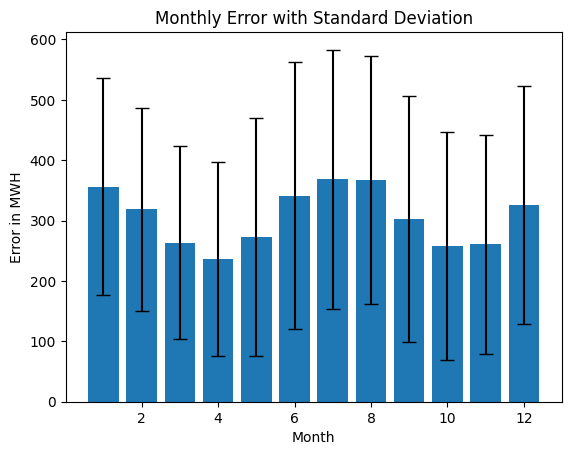

In [ ]:

# Assuming MonthErrors is a dictionary where:
# - keys are months
# - values are lists where the first element is the mean error and the second element is the standard deviation

# Extracting months, mean errors, and standard deviations
months = list(MonthErrors.keys())
mean_errors = [MonthErrors[key][0] for key in months]
std_devs = [MonthErrors[key][1] for key in months]
error_bars = [(0, std) for std in std_devs]

# Creating the bar plot with error bars
plt.bar(months, mean_errors, yerr=error_bars, capsize=5)  # capsize specifies the width of the horizontal line at the top of the error bar

plt.xlabel("Month")
plt.ylabel("Error in MWH")
plt.title("Monthly Error with Standard Deviation for Training")

plt.show()

In [ ]:
print(validation_df.columns.values)

['Date' 'Actual Val Output' 'Predicted Val Output']


In [ ]:
Errors = []

index = 0 
for prediction in validation_uncertainty_df["energy_demand_mean"]:
    Errors.append(mean_absolute_error([prediction], [np.float32(validation_df["Actual Val Output"].iloc[index])]))
    index+=1 

TrainingErrors = pd.DataFrame({"Date": validation_uncertainty_df["Date"], "Errors": Errors})
print(f"The average validation error: {np.mean(Errors)}")
print(f"The standard deviation of the validation error: ", np.std(Errors))

The average validation error: 142.62649155272322
The standard deviation of the validation error:  150.2223354764682


In [ ]:
MonthErrors = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[]}

for i in range(len(validation_uncertainty_df["Date"])):
    date = validation_uncertainty_df["Date"].iloc[i]
    MonthErrors[date.month].append(Errors[i])
    
for key in MonthErrors.keys():
    mean = np.mean(MonthErrors[key])
    std = np.std(MonthErrors[key])
    MonthErrors[key] = (mean, std)
    print(f"Month {key}: Mean Error: {mean}, Standard deviation: {std}")

Month 1: Mean Error: 118.44756618326599, Standard deviation: 95.80203227893094
Month 2: Mean Error: 105.26032195694145, Standard deviation: 81.53689128734719
Month 3: Mean Error: 112.77356383621051, Standard deviation: 94.36623917762812
Month 4: Mean Error: 164.07736850314672, Standard deviation: 126.95249143522399
Month 5: Mean Error: 206.0866430139029, Standard deviation: 139.19298963103097
Month 6: Mean Error: 142.2864568074544, Standard deviation: 103.92510814749905
Month 7: Mean Error: 164.42635550550236, Standard deviation: 135.23000944623627
Month 8: Mean Error: 249.9002227783203, Standard deviation: 343.26564850483646
Month 9: Mean Error: 103.16950666639539, Standard deviation: 83.01309334931523
Month 10: Mean Error: 85.04166601037467, Standard deviation: 72.33119986246592
Month 11: Mean Error: 106.6361339992947, Standard deviation: 105.59245059065316
Month 12: Mean Error: 148.7042760425429, Standard deviation: 110.63877117899848


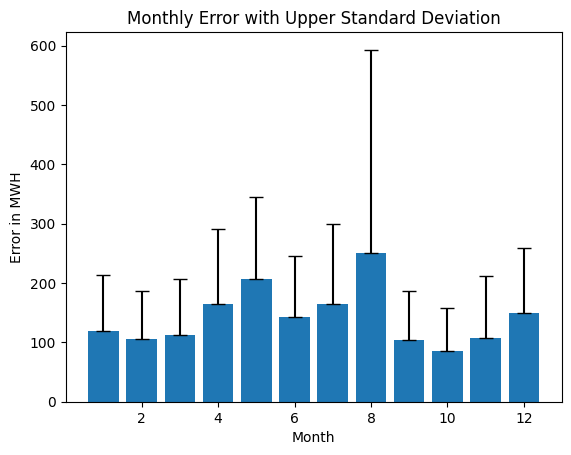

In [ ]:
import matplotlib.pyplot as plt

# Assuming MonthErrors is a dictionary where:
# - keys are months
# - values are lists where the first element is the mean error and the second element is the standard deviation

# Extracting months, mean errors, and standard deviations
months = list(MonthErrors.keys())
mean_errors = [MonthErrors[key][0] for key in months]
std_devs = [MonthErrors[key][1] for key in months]

# Specifying that the lower part of the error bar is 0 and the upper part is the standard deviation
error_bars = np.array([(0,)*len(std_devs), std_devs])

# Creating the bar plot with error bars
plt.bar(months, mean_errors, yerr=error_bars, capsize=5)

plt.xlabel("Month")
plt.ylabel("Error in MWH")
plt.title("Monthly Error with Upper Standard Deviation")

plt.show()

In [ ]:
#test_uncertainty_df.reset_index(inplace = True, drop = True)
Errors = []
index = 0 
for prediction in test_uncertainty_df["energy_demand_mean"]:
    Errors.append(mean_absolute_error([prediction], [np.float32(testing_df["Actual Test Output"].iloc[index])]))
    index+=1 

TrainingErrors = pd.DataFrame({"Date": test_uncertainty_df["Date"], "Errors": Errors})
print(f"The average validation error: {np.mean(Errors)}")
print(f"The standard deviation of the validation error: ", np.std(Errors))

The average validation error: 134.29482145505173
The standard deviation of the validation error:  122.67691049086028


In [ ]:
MonthErrors = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[]}

for i in range(len(test_uncertainty_df["Date"])):
    date = test_uncertainty_df["Date"].iloc[i]
    MonthErrors[date.month].append(Errors[i])
    
for key in MonthErrors.keys():
    mean = np.mean(MonthErrors[key])
    std = np.std(MonthErrors[key])
    MonthErrors[key] = (mean, std)
    print(f"Month {key}: Mean Error: {mean}, Standard deviation: {std}")

Month 1: Mean Error: 135.18898038498165, Standard deviation: 102.9366677059983
Month 2: Mean Error: 139.31101832314144, Standard deviation: 109.8977038227358
Month 3: Mean Error: 125.00034706908743, Standard deviation: 125.08219304459482
Month 4: Mean Error: 166.8566517582646, Standard deviation: 165.24465736925427
Month 5: Mean Error: 161.02209390619748, Standard deviation: 157.4744328516692
Month 6: Mean Error: 133.88663838704426, Standard deviation: 108.57089020634635
Month 7: Mean Error: 147.70042331927993, Standard deviation: 119.31557958059454
Month 8: Mean Error: 145.40481873652413, Standard deviation: 132.88406041731568
Month 9: Mean Error: 116.56155401159216, Standard deviation: 105.89919392558156
Month 10: Mean Error: 102.02410483958474, Standard deviation: 101.9011362305295
Month 11: Mean Error: 113.44039832221137, Standard deviation: 110.84655755615418
Month 12: Mean Error: 125.42552737437695, Standard deviation: 91.44336243821074


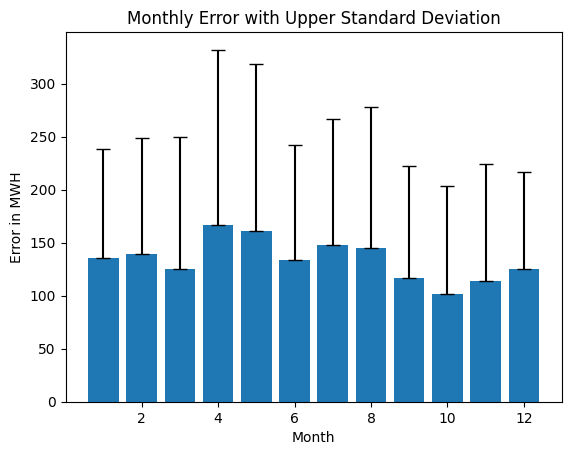

In [ ]:
import matplotlib.pyplot as plt

# Assuming MonthErrors is a dictionary where:
# - keys are months
# - values are lists where the first element is the mean error and the second element is the standard deviation

# Extracting months, mean errors, and standard deviations
months = list(MonthErrors.keys())
mean_errors = [MonthErrors[key][0] for key in months]
std_devs = [MonthErrors[key][1] for key in months]

# Specifying that the lower part of the error bar is 0 and the upper part is the standard deviation
error_bars = np.array([(0,)*len(std_devs), std_devs])

# Creating the bar plot with error bars
plt.bar(months, mean_errors, yerr=error_bars, capsize=5)

plt.xlabel("Month")
plt.ylabel("Error in MWH")
plt.title("Monthly Error with Upper Standard Deviation")

plt.show()

# Generating the dataframe for mean, lower, and upper bounds

In [ ]:
testing_df.drop(["Predicted Test Output"], axis = 1, inplace = True)
testing_df.insert(1, "99% lower_bound", test_uncertainty_df["99% lower_bound"])
testing_df.insert(2, "99.99% lower_bound", test_uncertainty_df["99.99% lower_bound"])
testing_df.insert(3, "99.999% lower_bound", test_uncertainty_df["99.999% lower_bound"])
testing_df.insert(4, "mean", test_uncertainty_df["energy_demand_mean"])
testing_df.insert(5, "99.999% upper_bound", test_uncertainty_df["99.999% upper_bound"])
testing_df.insert(6, "99.99% upper_bound", test_uncertainty_df["99.99% upper_bound"])
testing_df.insert(7, "99% upper_bound", test_uncertainty_df["99% upper_bound"])
testing_df.to_csv("TestingDataBounds2.csv", index = False)

In [ ]:
validation_df.drop(["Predicted Val Output"], axis = 1, inplace = True)
validation_df.insert(1, "99% lower_bound", validation_uncertainty_df["99% lower_bound"])
validation_df.insert(2, "99.99% lower_bound", validation_uncertainty_df["99.99% lower_bound"])
validation_df.insert(3, "99.999% lower_bound", validation_uncertainty_df["99.999% lower_bound"])
validation_df.insert(4, "mean", validation_uncertainty_df["energy_demand_mean"])
validation_df.insert(5, "99.999% upper_bound", validation_uncertainty_df["99.999% upper_bound"])
validation_df.insert(6, "99.99% upper_bound", validation_uncertainty_df["99.99% upper_bound"])
validation_df.insert(7, "99% upper_bound", validation_uncertainty_df["99% upper_bound"])
validation_df.to_csv("ValidationDataBounds2.csv", index = False)


In [ ]:
training_df.drop(["Predicted Train Output"], axis = 1, inplace = True)
training_df.insert(1, "99% lower_bound", training_uncertainty_df["99% lower_bound"])
training_df.insert(2, "99.99% lower_bound", training_uncertainty_df["99.99% lower_bound"])
training_df.insert(3, "99.999% lower_bound", training_uncertainty_df["99.999% lower_bound"])
training_df.insert(4, "mean", training_uncertainty_df["energy_demand_mean"])
training_df.insert(5, "99.999% upper_bound", training_uncertainty_df["99.999% upper_bound"])
training_df.insert(6, "99.99% upper_bound", training_uncertainty_df["99.99% upper_bound"])
training_df.insert(7, "99% upper_bound", training_uncertainty_df["99% upper_bound"])
training_df.to_csv("TrainingDataBounds2.csv", index = False)


# Conclusions

- Bayesian LSTMs have been able to produce comparable performance to their frequentist counterparts (all else being equal)
- Stochastic dropout enables users to approximate the posterior distribution of the target variable, \
and thus construct confidence intervals for each prediction
- Bayesian Neural Networks only attempt to account for epistemic model uncertainty and do not necessarily address aleatoric uncertainty
- Computational overhead for repeated/multiple Bayesian LSTM predictions at inference to construct confidence intervals represent a potential challenge for real-time inference use-cases.